In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from wordcloud import WordCloud

# Load the dataset
file_path = "/kaggle/input/afghanistan-cbe-dataset/Afghanistan_CBE.csv"  
data = pd.read_csv(file_path)



# Check the dataset
data.info()
data.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 14 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   SN (CBE)                                   1575 non-null   object 
 1   TYPE OF CBE (CBS/ALC) Classification name  1576 non-null   object 
 2   TYPE OF CBE (CBS/ALC) Grades               1575 non-null   object 
 3   L3_Province Name en                        1575 non-null   object 
 4   L4_District Name En                        1575 non-null   object 
 5   L4_District Code                           1575 non-null   object 
 6   VILLAGE NAME                               1575 non-null   object 
 7   CBE GPS coordinates - Latitude             1575 non-null   float64
 8   CBE GPS coordinates - Longitude            1575 non-null   float64
 9   TYPE OF CLASSROOM INFRASTRUCTURE           1575 non-null   object 
 10  DEMOGRAPHIC OF CBE      

,SN (CBE),TYPE OF CBE (CBS/ALC) Classification name,TYPE OF CBE (CBS/ALC) Grades,L3_Province Name en,L4_District Name En,L4_District Code,VILLAGE NAME,CBE GPS coordinates - Latitude,CBE GPS coordinates - Longitude,TYPE OF CLASSROOM INFRASTRUCTURE,DEMOGRAPHIC OF CBE,Number of boys enrolled,Number of girls enrolled,LANGUAGE OF INSTRUCTION
0,AF1103-00001,CBS,Grade 2,Panjsher,Shutul,AF1103029,Deh Kalan,35.194255,69.273412,Home Based,Girls,0.0,35.0,Dari
1,AF1103-00002,ALC,Level 1 (Grade 1 and Grade 2),Panjsher,Khenj,AF1103026,Zena,35.391413,69.674172,Home Based,Girls,0.0,33.0,Dari
2,AF1103-00003,CBS,Grade 2,Panjsher,Anawa,AF1103023,Qazi Khel -Tawakh,35.245762,69.401176,Home Based,Mixed,5.0,13.0,Dari
3,AF1103-00004,CBS,Grade 2,Panjsher,Rukha,AF1103028,Ghulestan Bala,35.256518,69.455030,Home Based,Mixed,10.0,9.0,Dari
4,AF1103-00005,CBS,Grade 2,Panjsher,Rukha,AF1103028,Ghulestan Payeen,35.256295,69.457024,Home Based,Mixed,10.0,9.0,Dari


In [2]:
# Renaming columns for convenience
data.columns = [
    "SN", "CBE_Type_Name", "CBE_Grade", "Province", "District", "District_Code",
    "Village", "Latitude", "Longitude", "Infrastructure", "Demographics",
    "Boys", "Girls", "Language"
]

In [3]:
data_cleaned = data.dropna()


In [4]:
print("\nMissing values:\n", data_cleaned.isnull().sum())


Missing values:
 SN                0
CBE_Type_Name     0
CBE_Grade         0
Province          0
District          0
District_Code     0
Village           0
Latitude          0
Longitude         0
Infrastructure    0
Demographics      0
Boys              0
Girls             0
Language          0
dtype: int64


# Looks like most of our data is behaving well. But let's make sure we handle any stragglers! 🧐


In [5]:
# Create a Pivot Table
pivot_table = pd.pivot_table(
    data_cleaned,
    values=['Boys', 'Girls'],  # Values to summarize
    index=['Province'],  # Province as rows
    columns=['CBE_Grade'],  # Grades as columns
    aggfunc='sum',  # Aggregate by sum
    fill_value=0  # Fill missing values with 0
)

In [6]:
# Group the data by province to see how many CBE classes exist in each
cbe_classes_by_province = data_cleaned.groupby('Province').size()

In [7]:
# Number of Girls Classes by Province
girls_classes_by_province = data_cleaned[data_cleaned['Demographics'] == 'Girls'].groupby('Province').size()



In [8]:
# Percentage of Enrolled Girls by Province
total_students_by_province = data_cleaned.groupby('Province')[['Boys', 'Girls']].sum()
total_students_by_province['Percentage Girls'] = (
    total_students_by_province['Girls'] /
    (total_students_by_province['Boys'] + total_students_by_province['Girls']) * 100
)

In [9]:
print("📊 CBE Classroom Gender Breakdown (Boys vs Girls per Province & Grade):")
print(pivot_table)

📊 CBE Classroom Gender Breakdown (Boys vs Girls per Province & Grade):
              Boys                                                \
CBE_Grade  Grade 2 Grade 4 Grade 5 Level 1 (Grade 1 and Grade 2)   
Province                                                           
Badakhshan  2316.0     0.0     0.0                           0.0   
Hirat          0.0   229.0   581.0                           0.0   
Jawzjan     1430.0     0.0     0.0                           0.0   
Kunduz      1931.0     0.0     0.0                           0.0   
Panjsher    1384.0     0.0     0.0                          81.0   
Parwan      1829.0     0.0     0.0                           0.0   
Samangan     642.0     0.0     0.0                         243.0   
Sar-e-Pul   1260.0     0.0     0.0                         180.0   
Uruzgan     2949.0     0.0     0.0                           0.0   
Zabul       1326.0     0.0     0.0                           0.0   

                                            

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128218 (\N{BOOKS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


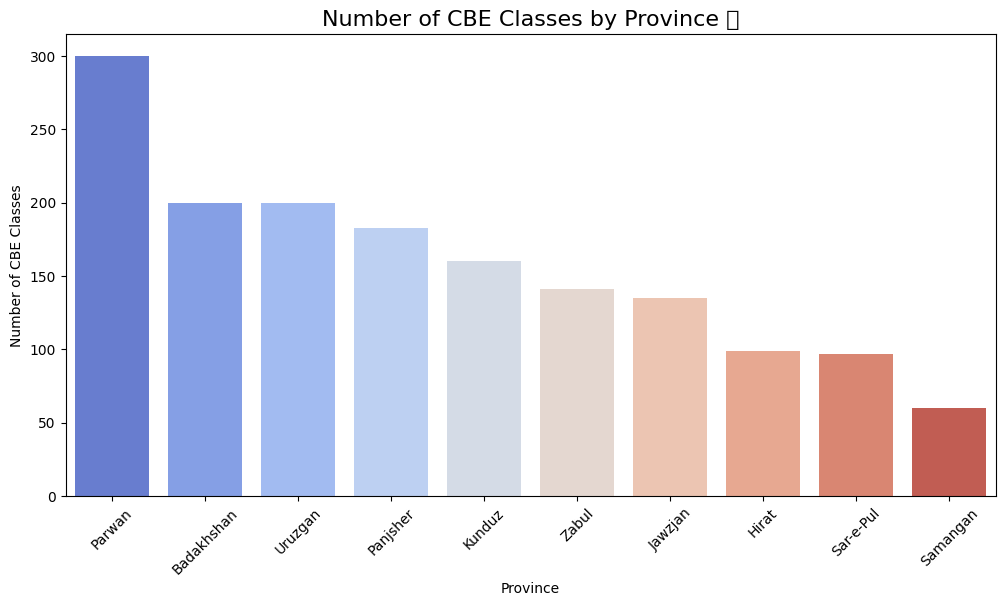


👧 Number of Girls-Only CBE Classes by Province:
Province
Badakhshan     55
Hirat          27
Jawzjan        46
Kunduz         40
Panjsher       71
Parwan        218
Samangan       13
Sar-e-Pul      49
Uruzgan         5
Zabul           1
dtype: int64


In [10]:
# Visualizing the number of CBE classes by Province
plt.figure(figsize=(12, 6))
sns.barplot(x=cbe_classes_by_province.index, 
            y=cbe_classes_by_province.values, 
            palette='coolwarm', 
            order=cbe_classes_by_province.sort_values(ascending=False).index)
plt.title("Number of CBE Classes by Province 📚", fontsize=16)
plt.xlabel("Province")
plt.ylabel("Number of CBE Classes")
plt.xticks(rotation=45)
plt.show()


print("\n👧 Number of Girls-Only CBE Classes by Province:")
print(girls_classes_by_province)

# Some provinces seem to have more CBEs. Education is definitely climbing mountains in Afghanistan! 🏔️


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127891 (\N{GRADUATION CAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


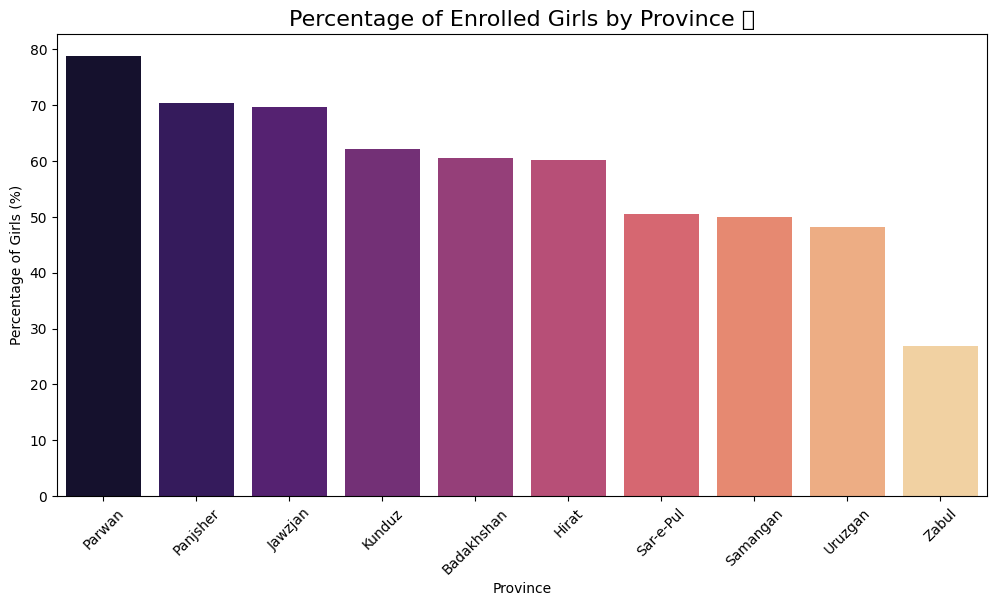


🎒 Percentage of Girls Enrolled by Province:
            Percentage Girls
Province                    
Badakhshan         60.551302
Hirat              60.169114
Jawzjan            69.735450
Kunduz             62.218009
Panjsher           70.398060
Parwan             78.801941
Samangan           49.971735
Sar-e-Pul          50.481431
Uruzgan            48.189895
Zabul              26.850095


In [11]:
# Visualizing the percentage of enrolled girls by province
plt.figure(figsize=(12, 6))
sns.barplot(x=total_students_by_province.index, 
            y=total_students_by_province['Percentage Girls'], 
            palette='magma', 
            order=total_students_by_province.sort_values('Percentage Girls', ascending=False).index)
plt.title("Percentage of Enrolled Girls by Province 🎓", fontsize=16)
plt.xlabel("Province")
plt.ylabel("Percentage of Girls (%)")
plt.xticks(rotation=45)
plt.show()

# Displaying the table for percentage of girls enrolled by province
print("\n🎒 Percentage of Girls Enrolled by Province:")
print(total_students_by_province[['Percentage Girls']])


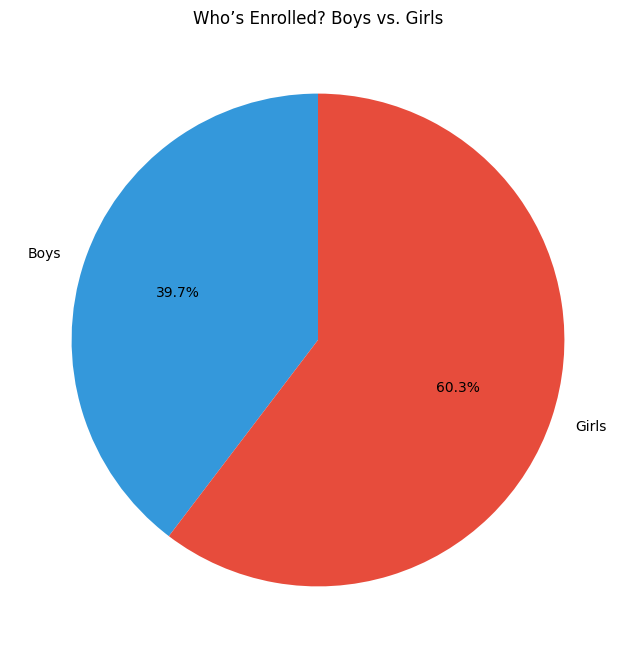

In [12]:
# Total boys and girls enrolled
boys = data_cleaned['Boys'].sum()
girls = data_cleaned['Girls'].sum()

# Pie chart
labels = ['Boys', 'Girls']
sizes = [boys, girls]
colors = ['#3498db', '#e74c3c']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Who’s Enrolled? Boys vs. Girls")
plt.show()


# Girls in CBE were closing the gap, proving that education truly is for everyone! 🎓

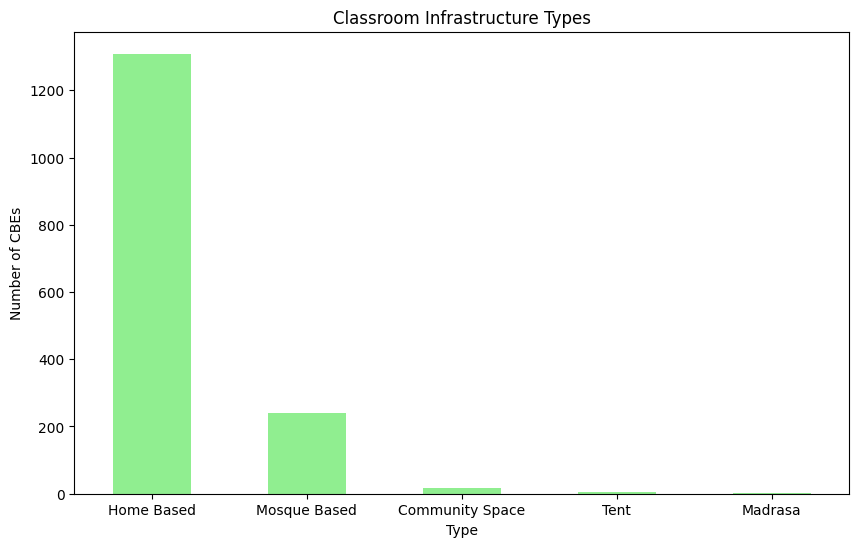

In [13]:
# Count of CBEs by infrastructure type
infra_counts = data_cleaned['Infrastructure'].value_counts()

# Bar chart
infra_counts.plot(kind='bar', color='lightgreen', figsize=(10, 6))
plt.title("Classroom Infrastructure Types")
plt.xlabel("Type")
plt.ylabel("Number of CBEs")
plt.xticks(rotation=0)
plt.show()


# Home-based vs Mosque-based: Education knows no boundaries—just a roof (or lack thereof)! 🏡


In [14]:
# Define valid latitude and longitude range for Afghanistan
lat_min, lat_max = 29, 38
lon_min, lon_max = 60, 77

# Filter out rows with Latitude and Longitude outside of Afghanistan's valid range
data = data_cleaned[(data_cleaned['Latitude'] >= lat_min) & (data_cleaned['Latitude'] <= lat_max) & 
            (data_cleaned['Longitude'] >= lon_min) & (data_cleaned['Longitude'] <= lon_max)]


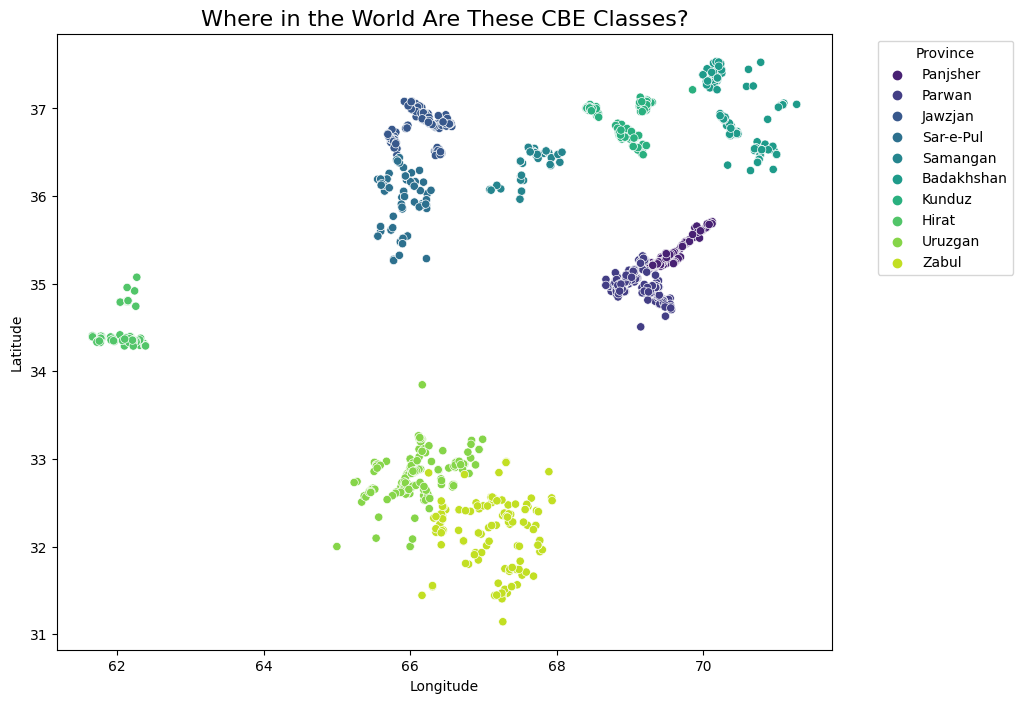

In [15]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='Longitude', y='Latitude', hue='Province', palette='viridis')
plt.title("Where in the World Are These CBE Classes?", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Province", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [16]:
# Creating a map to plot CBEs
m = folium.Map(location=[34.5, 67.5], zoom_start=6)

# Adding markers for CBEs
for _, row in data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=(
            f"<b>Province:</b> {row['Province']}<br>"
            f"<b>District:</b> {row['District']}<br>"
            f"<b>Class Type:</b> {row['CBE_Type_Name']}<br>"
            f"<b>Boys:</b> {int(row['Boys'])}, <b>Girls:</b> {int(row['Girls'])}<br>"
            f"<b>Infrastructure:</b> {row['Infrastructure']}"
        ),
        icon=folium.Icon(color='blue' if row['Infrastructure'] == 'Home-Based' else 'green')
    ).add_to(m)

# Show the map
m


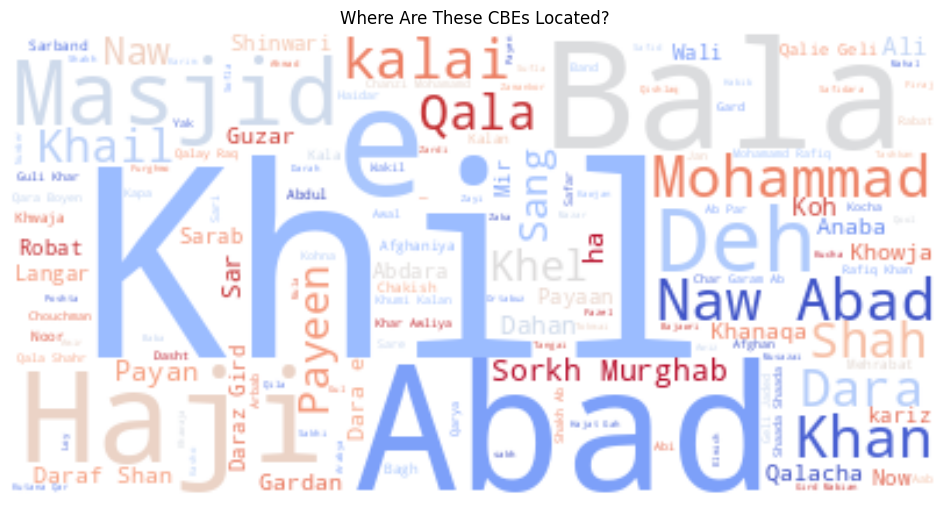

In [17]:
# Generate word cloud for villages
village_text = " ".join(data['Village'].dropna())

wordcloud = WordCloud(background_color='white', colormap='coolwarm').generate(village_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Where Are These CBEs Located?")
plt.show()


# Who knew village names could look so artistic? Maybe there’s a poetry class hidden in this dataset.


# Conclusion

The Community-Based Education (CBE) program in Afghanistan plays a crucial role in providing education to children in rural and conflict-affected areas. Despite challenges such as infrastructure limitations and geographic isolation, CBE has expanded access to education for thousands of children, particularly girls, in hard-to-reach areas.

The data reveals the effectiveness of CBE in meeting the educational needs of communities and the adaptability of the program in using local resources like homes, mosques, and community spaces to create classrooms.
